In [55]:
import json 
import nltk
import re
import pandas as pd
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer 
import numpy as np


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [77]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Masa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Masa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [124]:
with open("data/filtered/abusive_hateful_spam_normal.json") as f:
    data = json.load(f)

data_tag = 'ahs'  # can also be 'srb or 'ahs' for the other dataset
print(data)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



#### Separating the tweets depending on their label - sexism, benevolent, racism , or both (tweet gets added into sexism and racism list)

In [163]:
if data_tag == 'srb':
    racism = []
    benevolent = []
    sexism = []
    for id, tweet in data.items():
        text = tweet["text"]
        if(len(text) == 0):
            continue
        if tweet["label"] == "sexism":
            sexism.append(text)
        if tweet["label"] == "benevolent":
            benevolent.append(text)
        if tweet["label"] == "racism":
            racism.append(text)
        if tweet["label"] == "both":
            sexism.append(text)
            racism.append(text)
    print(len(racism))
    print(len(sexism))
    print(len(benevolent))

    labels = []
    #labels.extend(["R"] * len(racism))
    #labels.extend(["S"] * len(sexism))
    labels.extend(["B"] * len(benevolent))
    print(len(labels))

    texts = []
    #texts.extend(racism)
    texts.extend(benevolent)
    #texts.extend(sexism)
    print(len(texts))
    
if data_tag == 'ahs':
    abusive = []
    hateful = []
    spam = []
    for id, tweet in data.items():
        text = tweet["text"]
        if(len(text) == 0):
            continue
        if tweet["label"] == "abusive":
            abusive.append(text)
        if tweet["label"] == "hateful":
            hateful.append(text)
        if tweet["label"] == "spam":
            spam.append(text)
    
    print(len(abusive))
    print(len(hateful))
    print(len(spam))

    labels = []
    #labels.extend(["A"] * len(abusive))
    #labels.extend(["H"] * len(hateful))
    labels.extend(["S"] * len(spam))
    print(len(labels))

    texts = []
    #texts.extend(abusive)
    #texts.extend(hateful)
    texts.extend(spam)
    print(len(texts))

print(labels)

4227
1752
7782
7782
7782
['S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S',

#### Preprocessing our tweets by removing retweet text RT, hyperlinks, hashtags, taggs @, new lines, and zero length tweets

In [164]:
def preprocess(A, labels):
    B = []
    labels_new = []
    for i in range(len(A)):

        text = A[i]
        # remove old style retweet text "RT"
        text = re.sub(r'^RT[\s]+', '', text)

        # remove hyperlinks
        text= re.sub(r'https?:\/\/.*[\r\n]*', '', text)

        # remove hashtags
        # only removing the hash # sign from the word
        text = re.sub(r'#', '', text)

        # remove tagging @
        text = re.sub(r"(?:\@|https?\://)\S+", "", text)

        # remove new line \n
        text = re.sub("\n", "", text)

        # remove zero length tweets
        if(len(text) == 0 ):
            continue

        B.append(text)
        labels_new.append(labels[i])
    return B, labels_new

In [165]:
texts, labels = preprocess(texts, labels)
len(texts)

7724

#### Merge lists into one large list of tweets. Filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation).

In [166]:

tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
"""
def tokenize(text):
    filtered_tokens = []
    tweet_tokens = tokenizer.tokenize(text)

    for token in tweet_tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

"""
def tokenize_only(text):
    # First tokenize by sentence, then by word to ensure that punctuation is caught as it's own token.
    #tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    tokens = tokenizer.tokenize(text)
    filtered_tokens = []
    # Filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation).
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens
stemmer = SnowballStemmer("english")


def tokenize_and_stem(text):
    #tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    tokens = tokenizer.tokenize(text)
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)

    #exclude stopwords from stemmed words
    stems = [stemmer.stem(t) for t in filtered_tokens]
    
    return stems



In [167]:
#racism = tokenize_lists(racism)
#sexism = tokenize_lists(sexism)
#benevolent = tokenize_lists(benevolent)

In [170]:
texts

['JAP Battle (EXPLICIT) - "Crazy Ex-Girlfriend" Awe Snap, Scarsdale!!! ',
 ' THAT IS A FUCKING MOVIE! ',
 'Just watched  woahhhhh break my fucking heart! RIP Fiona  ',
 ' [!!] WINNER trending on Melon Search🍈FateNumberForReallyReally💚💜💛💙 ',
 '     Something Something Idiot',
 ' [!!!] WINNER 1 trending on MelOn search ',
 'Push your cock inside me,i am a bad police,punish me ',
 "bulletsandbeesboutique's video ",
 " Me tweeting like I'm miserable knowing damn well I got the man of my dreams in my iMessages rn ",
 'Ant and Dick have nothing on this ',
 ' [!!] WINNER trending 1 on melon search위너_4일4시_음원공개FateNumberFor ',
 '“THE FORCE AWAKENS: A Bad Lip Reading” (Featuring Mark Hamill as Han\xa0Solo) ',
 ' [PIC] 170407 Han Seonhwa Instagram Update - Hoya ',
 ' Dangal all set to beat 3Idiots in Taiwan.Historic collections',
 'just fucking kidding! scored ',
 'Socialist Scumbags Shucky Schumer,Fauxcahontas Sacajawea Warren,Dementia-Riddled Retard Pelosi must be stopped!!! 🔥👿 ',
 ' [!!] Reall

In [171]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in texts:
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed)
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

# Create a pandas DataFrame
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)

print("There are '{}' items in our data frame.".format(str(vocab_frame.shape[0])))
print("Data frame contents: \n{}".format(vocab_frame.head(10)))

There are '92084' items in our data frame.
Data frame contents: 
                       words
jap                      jap
battl                 battle
explicit            explicit
crazi                  crazy
ex-girlfriend  ex-girlfriend
awe                      awe
snap                    snap
scarsdal           scarsdale
that                    that
is                        is


#### TF-IDF

In [174]:
# Define vectorizer parameters

tfidf_vectorizer = TfidfVectorizer(
                        max_df=0.50, 
                        max_features=None,
                        min_df=2,  
                        use_idf=True, 
                        stop_words="english",
                        tokenizer=tokenize_and_stem, 
                        ngram_range=(1,1))

#tfidf_vectorizer = TfidfVectorizer()

# Fit the vectorizer to synopses texts
%time tfidf_matrix = tfidf_vectorizer.fit_transform(texts) 


print("TF-IDF matrix shape: {}".format(tfidf_matrix.shape))

Wall time: 2.49 s
TF-IDF matrix shape: (7724, 5356)


In [175]:
feature_array = np.array(tfidf_vectorizer.get_feature_names())
tfidf_sorting = np.argsort(tfidf_matrix.toarray()).flatten()[::-1]

n = 5
top_n = feature_array[tfidf_sorting][:n]
print(top_n)

['inspiron' 'laptop' "i'v" 'giveaway' 'game']


#### Use cosine similarity

In [46]:
terms = tfidf_vectorizer.get_feature_names()

dist = 1 - cosine_similarity(tfidf_matrix)
print(dist)

[[ 0.00000000e+00  9.38065228e-01  8.86972109e-01 ...  1.00000000e+00
   1.00000000e+00  1.00000000e+00]
 [ 9.38065228e-01 -2.22044605e-16  8.76435156e-01 ...  1.00000000e+00
   1.00000000e+00  1.00000000e+00]
 [ 8.86972109e-01  8.76435156e-01  0.00000000e+00 ...  1.00000000e+00
   1.00000000e+00  1.00000000e+00]
 ...
 [ 1.00000000e+00  1.00000000e+00  1.00000000e+00 ...  0.00000000e+00
   9.07823050e-01  6.85431658e-01]
 [ 1.00000000e+00  1.00000000e+00  1.00000000e+00 ...  9.07823050e-01
  -2.22044605e-16  7.06973216e-01]
 [ 1.00000000e+00  1.00000000e+00  1.00000000e+00 ...  6.85431658e-01
   7.06973216e-01  0.00000000e+00]]


#### Use k-means clustering
##### First choose optimal number of clusters using the silhouette score

In [27]:
range_clusters = list(range(2,10))
for num_clusters in range_clusters:
    km = KMeans(n_clusters=num_clusters)
    km.fit(tfidf_matrix)
    clusters = km.labels_.tolist()
    silhouette_avg = silhouette_score(tfidf_matrix, clusters)
    print(f"{num_clusters} clusters - silhouette: {silhouette_avg}")

2 clusters - silhouette: 0.039750487492271676
3 clusters - silhouette: 0.0495955113167516
4 clusters - silhouette: 0.05001014692011948
5 clusters - silhouette: 0.051557616610219424
6 clusters - silhouette: 0.05112886934195982
7 clusters - silhouette: 0.05483452862280078
8 clusters - silhouette: 0.0578541350405291
9 clusters - silhouette: 0.05817085771858932


In [50]:
num_clusters = 3
km = KMeans(n_clusters=num_clusters)

# Perform clustering
%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()
print("Clusters: {}".format(clusters))

print(len(clusters))

Wall time: 3.28 s
Clusters: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

#### Get number of tweets per cluster

In [51]:
tweets = {"label": labels, "text": texts, "cluster": clusters}
frame = pd.DataFrame(tweets, index = [clusters] , columns = ["label", "text", "cluster"])

print("Number of tweets per cluster: \n{}".format(frame["cluster"].value_counts()))

Number of tweets per cluster: 
0    2455
2     787
1     299
Name: cluster, dtype: int64


In [52]:
print("Top terms per cluster:\n")

# Sort cluster centers by proximity to centroid.
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
print(order_centroids)

# Helper function
def getClusterWords(cluster, n=10):
    words = []
    for ind in order_centroids[cluster, :n]: # Print 6 words per cluster
        words.append(vocab_frame.loc[terms[ind].split(' '),].values.tolist()[0][0])
    return ", ".join(words)

for i in range(num_clusters):
    print("Cluster {} words: {}".format(i, getClusterWords(i)))
    
    print("Cluster {} labels:".format(i), end='')
    
    for label in frame[frame["cluster"]==i]["label"].values.tolist():
        print(" {},".format(label), end='')
    print("\n")

Top terms per cluster:

[[136 107 240 106 145 119 135  74  67  44 215 171 113  65  17  66 234 140
  129 176 238 228  69 239 153  23 125  76 165 218  26 131  24  53  59 251
   28 214 149   2 146  84  63 137 159 236 168 250  35  39  93 134 193 174
   16 226  43  54  90  40 249 157 167 117 130  42  77 243 201   5 128 142
   32   6 212  78 210  80 221 195 124 138 231 230 205 182  21 207 190 154
   72  61 152  89   7 164 202 108 244 224 158  14 104 100 213  51 127 235
  208 109 111   1 147 203  25 141 166  38 116  18 105 114  13  48 247 192
  241  79  87 222  82  10 211  60 144  41  50 175 181 161 160 248 163  73
   86 232 227 132  85 170  92 173 148  36  58  11  71   9 180 229  70  55
   75 178  81  45 219  27 103  49  29 233 126 150 209  20   4 246  52  19
    0 245 225 112 199 194  99  83 169 177  91 143 223 217 122  22 118 139
    3 123  57 110 179 121  30 200 162  62 204 198 133 115  31  15  88 155
   47 172 197 242 156  34 220 191  56 120  68  33  37 237  46 196 151 101
   64  12   8 

Cluster 2 words: sexist, i'm, i'm, women's, female, girls, sexist, just, woman, im
Cluster 2 labels: S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S,

#### Plotting

In [124]:
from sklearn.manifold import MDS

# Parameter "precomputed" because we provide a distance matrix.
# Parameter "random_state" so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

# Shape of the result will be (n_components, n_samples).
pos = mds.fit_transform(dist)  

xs, ys = pos[:, 0], pos[:, 1]

KeyboardInterrupt: 

In [109]:
# Define colors for clusters.
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

# Define cluster names
cluster_names = dict([(i, getClusterWords(i, 3)) for i in range(5)])

KeyError: 'title'

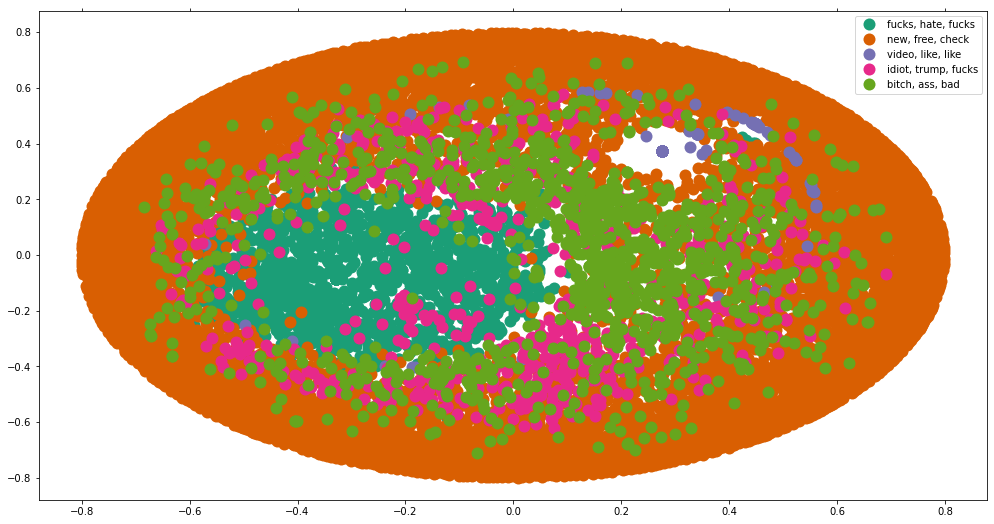

In [111]:
import matplotlib.pyplot as plt
import matplotlib as mpl
# Enable to draw plot inline.
%matplotlib inline

# Create a data frame that has the result of the MDS plus the cluster numbers and titles.
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters)) 

# Group by cluster.
groups = df.groupby('label')


# Set up plot.
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

# Iterate through groups to layer the plot.
# Note that we use the cluster_name and cluster_color dicts with the 'name' 
# lookup to return the appropriate color/label.
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',         # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',        # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

# Add label in x,y position with the label as the film title.
for i in range(len(df)):
    # old pandas:
    #ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8) 
    ax.text(df.loc[df.index[i], 'x'], df.loc[df.index[i], 'y'], df.loc[df.index[i], 'title'], size=8)  

# Uncomment the below to show or save the plot.
plt.show()                                       #show the plot
#plt.savefig('clusters_small_noaxes.png', dpi=200) # save the plot as an image 

plt.close()